In [1]:
%load_ext autoreload
%autoreload 2
import geopandas as gpd
from shapely.geometry import LineString, Point
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import folium
import hvplot.pandas

# Visualización de la Matriz OD

Vamos a visualizar la martiz que obtuvimos en el notebook `01-matrizOD`. Lo que vamos a hacer es obtener los centroides de cada una de las zonas y crear líneas que unan los centroides de acuerdo a los resultados de la matriz. Los pesos de las líneas serán la cantidad de viajes promedio.

## Centroides de las zonas de análisis


Obtenemos los centroides

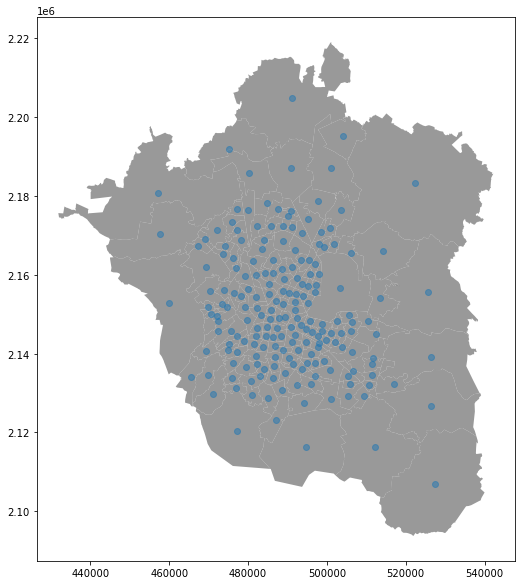

In [2]:
zonas = gpd.read_file("../data/DistritosEODHogaresZMVM2017.shp")
centros = zonas.copy()
centros['geometry'] = centros['geometry'].centroid
fig , ax = plt.subplots(1, figsize=(15,10))
zonas.plot(ax=ax, facecolor='grey', alpha=0.8)
centros.plot(ax=ax, alpha=0.5)
plt.show()

## Unir con la matriz

Ya tenemos los centroides, ahora vamos a unirlos con la matriz OD. Necesitamos asignar un punto al distrito de origen y uno al de destino para hacer las líneas

In [3]:
matriz = pd.read_csv("../output/matriz_od_semana.csv", skiprows=1, dtype={'distrito_origen':str, 'distrito_destino':str})
matriz.drop(['Unnamed: 0'], axis=1, inplace=True)
matriz

,intervalo,distrito_origen,distrito_destino,sum,mean,std
0,02:00:00,001,001,45,2.250000,1.371707
1,02:00:00,001,002,24,1.411765,0.507300
2,02:00:00,001,003,3,1.000000,0.000000
3,02:00:00,001,004,1,1.000000,NaN
4,02:00:00,001,006,2,1.000000,0.000000
...,...,...,...,...,...,...
26796,23:00:00,174,174,2,2.000000,NaN
26797,23:00:00,188,186,1,1.000000,NaN
26798,23:00:00,192,192,1,1.000000,NaN
26799,23:00:00,195,195,1,1.000000,NaN


Seleccionamos un intervalo, por ejemplo en la mañana cuando todos se están yendo a trabajar, además seleccionemos sólo los que tengan más de diez viajes en total

In [4]:
morning = matriz.loc[(matriz['intervalo'] == '06:00:00') & (matriz['sum'] > 10)].copy()
morning

,intervalo,distrito_origen,distrito_destino,sum,mean,std
1304,06:00:00,001,001,213,9.260870,2.942130
1305,06:00:00,001,002,73,3.173913,1.585507
1310,06:00:00,001,007,12,1.714286,0.755929
1311,06:00:00,001,008,18,1.636364,0.924416
1312,06:00:00,001,009,12,1.090909,0.301511
...,...,...,...,...,...,...
5141,06:00:00,172,172,14,1.555556,1.333333
5159,06:00:00,174,174,34,2.000000,1.172604
5288,06:00:00,193,193,11,1.222222,0.440959
5395,06:00:00,207,207,14,1.400000,0.699206


Para esta visualización, tomemos sólo los viajes entre zonas de análisis, es decir, aquellos en los que el origen y el destino sean diferentes

In [5]:
morning =  morning.loc[morning['distrito_origen'] != morning['distrito_destino']]
morning

,intervalo,distrito_origen,distrito_destino,sum,mean,std
1305,06:00:00,001,002,73,3.173913,1.585507
1310,06:00:00,001,007,12,1.714286,0.755929
1311,06:00:00,001,008,18,1.636364,0.924416
1312,06:00:00,001,009,12,1.090909,0.301511
1318,06:00:00,001,016,32,1.882353,0.992620
...,...,...,...,...,...,...
4563,06:00:00,126,058,37,2.312500,1.195478
4599,06:00:00,127,128,26,1.857143,0.949262
4620,06:00:00,128,113,18,2.250000,1.281740
4643,06:00:00,130,002,17,1.888889,1.269296


Ahora vamos a unir dos veces con los centroides, una usando `distrito_origen` y otra usando `distrito_destino`

In [6]:
morning = (morning.merge(centros, left_on='distrito_origen', right_on='Distrito')
             .drop('Descripcio', axis=1)
             .rename({'geometry':'point_origen'}, axis=1)
             .merge(centros, left_on='distrito_destino', right_on='Distrito')
             .drop(['Descripcio', 'Distrito_y', 'Distrito_x'], axis=1)
             .rename({'geometry':'point_destino'}, axis=1)
          )
morning

,intervalo,distrito_origen,distrito_destino,sum,mean,std,point_origen,point_destino
0,06:00:00,001,002,73,3.173913,1.585507,POINT (485576.548 2148785.591),POINT (483381.514 2149828.572)
1,06:00:00,003,002,32,2.000000,0.894427,POINT (485804.074 2150916.018),POINT (483381.514 2149828.572)
2,06:00:00,005,002,12,1.333333,0.500000,POINT (489440.769 2149240.057),POINT (483381.514 2149828.572)
3,06:00:00,006,002,15,1.666667,0.866025,POINT (487457.360 2146516.688),POINT (483381.514 2149828.572)
4,06:00:00,007,002,19,1.266667,1.032796,POINT (484798.072 2146697.465),POINT (483381.514 2149828.572)
...,...,...,...,...,...,...,...,...
284,06:00:00,110,105,15,1.500000,0.707107,POINT (476558.074 2155429.992),POINT (474697.913 2151796.749)
285,06:00:00,110,111,68,3.578947,1.346427,POINT (476558.074 2155429.992),POINT (469256.505 2161820.586)
286,06:00:00,111,112,15,1.500000,0.707107,POINT (469256.505 2161820.586),POINT (476860.808 2161777.223)
287,06:00:00,116,112,13,1.444444,0.726483,POINT (476223.104 2164253.891),POINT (476860.808 2161777.223)


Hacemos líneas entre origen y destino

In [7]:
morning['geometry'] = morning.apply(lambda x: LineString([x['point_origen'], x['point_destino']]), axis=1)
morning.drop(['point_origen', 'point_destino'], axis=1, inplace=True)
morning = gpd.GeoDataFrame(morning)
morning

,intervalo,distrito_origen,distrito_destino,sum,mean,std,geometry
0,06:00:00,001,002,73,3.173913,1.585507,"LINESTRING (485576.548 2148785.591, 483381.514..."
1,06:00:00,003,002,32,2.000000,0.894427,"LINESTRING (485804.074 2150916.018, 483381.514..."
2,06:00:00,005,002,12,1.333333,0.500000,"LINESTRING (489440.769 2149240.057, 483381.514..."
3,06:00:00,006,002,15,1.666667,0.866025,"LINESTRING (487457.360 2146516.688, 483381.514..."
4,06:00:00,007,002,19,1.266667,1.032796,"LINESTRING (484798.072 2146697.465, 483381.514..."
...,...,...,...,...,...,...,...
284,06:00:00,110,105,15,1.500000,0.707107,"LINESTRING (476558.074 2155429.992, 474697.913..."
285,06:00:00,110,111,68,3.578947,1.346427,"LINESTRING (476558.074 2155429.992, 469256.505..."
286,06:00:00,111,112,15,1.500000,0.707107,"LINESTRING (469256.505 2161820.586, 476860.808..."
287,06:00:00,116,112,13,1.444444,0.726483,"LINESTRING (476223.104 2164253.891, 476860.808..."


## Mapas

### Geopandas
Primero, el más sencillo de todos, sólo con geopandas

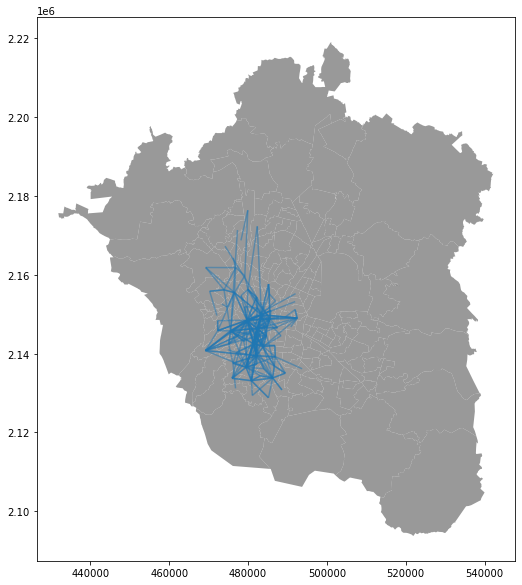

In [8]:
fig , ax = plt.subplots(1, figsize=(15,10))
zonas.plot(ax=ax, facecolor='grey', alpha=0.8)
morning.plot(ax=ax, alpha=0.5)
plt.show()

### Folium
Luego uno con folium, un poco más bonito

In [9]:
morning.crs = "EPSG:32614"
m = folium.Map()
folium.Choropleth(morning).add_to(m)
bounds = [[morning.to_crs("EPSG:4326").total_bounds[1], morning.to_crs("EPSG:4326").total_bounds[0]], 
          [morning.to_crs("EPSG:4326").total_bounds[3], morning.to_crs("EPSG:4326").total_bounds[2]]]
m.fit_bounds(bounds)
m

### Holoviews
Ahora con holoviews haciendo el ancho de las líneas proporcional al promedio de viajes

In [35]:
(morning.hvplot.paths(title='Flujos entre Distritos de la encuesta OD', geo=True, hover_cols=['mean'], line_width='mean', 
                     alpha=0.3, color='#fc6603', 
                     tiles='CartoDark', crs="EPSG:32614", width=800, height=650) *
zonas.hvplot(geo=True, color='Distrito', alpha=0.1, crs="EPSG:32614", legend=False))

:Overlay
   .Tiles.I    :Tiles   [x,y]
   .Path.I     :Path   [Longitude,Latitude]   (mean)
   .Polygons.I :Polygons   [Longitude,Latitude]   (Distrito)

Tmbién podemos poner lado a lado dos intervalos de tiempo

In [44]:
afternoon = matriz.loc[(matriz['intervalo'] == '18:00:00') & (matriz['sum'] > 10)].copy()
afternoon =  afternoon.loc[afternoon['distrito_origen'] != afternoon['distrito_destino']]
afternoon = (afternoon.merge(centros, left_on='distrito_origen', right_on='Distrito')
             .drop('Descripcio', axis=1)
             .rename({'geometry':'point_origen'}, axis=1)
             .merge(centros, left_on='distrito_destino', right_on='Distrito')
             .drop(['Descripcio', 'Distrito_y', 'Distrito_x'], axis=1)
             .rename({'geometry':'point_destino'}, axis=1)
          )
afternoon['geometry'] = afternoon.apply(lambda x: LineString([x['point_origen'], x['point_destino']]), axis=1)
afternoon.drop(['point_origen', 'point_destino'], axis=1, inplace=True)
afternoon = gpd.GeoDataFrame(afternoon)

In [47]:
(morning.hvplot.paths(title='Flujos en la mañana (6 a 10)', geo=True, hover_cols=['mean'], line_width='mean', 
                     alpha=0.3, color='#fc6603', 
                     tiles='CartoDark', crs="EPSG:32614", width=600, height=650) *
zonas.hvplot(geo=True, color='Distrito', alpha=0.1, crs="EPSG:32614", legend=False) + 
afternoon.hvplot.paths(title='Flujos en la tarde (18 a 22)', geo=True, hover_cols=['mean'], line_width='mean', 
                     alpha=0.3, color='#fc6603', 
                     tiles='CartoDark', crs="EPSG:32614", width=600, height=650) *
zonas.hvplot(geo=True, color='Distrito', alpha=0.1, crs="EPSG:32614", legend=False))

:Layout
   .Overlay.I  :Overlay
      .Tiles.I    :Tiles   [x,y]
      .Path.I     :Path   [Longitude,Latitude]   (mean)
      .Polygons.I :Polygons   [Longitude,Latitude]   (Distrito)
   .Overlay.II :Overlay
      .Tiles.I    :Tiles   [x,y]
      .Path.I     :Path   [Longitude,Latitude]   (mean)
      .Polygons.I :Polygons   [Longitude,Latitude]   (Distrito)

In [ ]:
matri